In [ ]:
WORKING_DIR = "/home/xavier/Documents/DAE_project"

# Collect model and LS3934 selected frames

In [2]:
import pandas as pd
import os
import shutil
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import dnnlib
import legacy
import torch
from training.networks_stylegan2 import SynthesisLayer


def resize_crop(img_name, resize_by=1., resolution=512, brightness_norm=True, brightness_mean=107):
    if isinstance(img_name, str):
        img = cv2.imread(img_name, cv2.IMREAD_UNCHANGED)
    else:
        img = img_name
    if img.dtype != np.uint8:
        img = np.uint8(img / 256)
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_shape = img.shape
    resize_shape = np.array([img_shape[1] * resize_by, img_shape[0] * resize_by], dtype=int)
    if resize_by != 1:
        img = cv2.resize(img, resize_shape, cv2.INTER_LANCZOS4)
    img = img[(resize_shape[1] - resolution) // 2:(resize_shape[1] + resolution) // 2,
    (resize_shape[0] - resolution) // 2:(resize_shape[0] + resolution) // 2]
    if brightness_norm:
        obj_v = np.mean(img)
        value = brightness_mean - obj_v
        img = cv2.add(img, value)
    return img


MODEL_DIR = f"{WORKING_DIR}/models/network-snapshot-001512-patched.pkl"

os.environ['CC'] = "/usr/bin/gcc-9"
os.environ['CXX'] = "/usr/bin/g++-9"
device = torch.device('cuda')


def reset_noise_const(G, seed):
    torch.manual_seed(seed)

    for block in G.synthesis.children():
        for layer in block.children():
            if isinstance(layer, SynthesisLayer):
                resolution = layer.resolution

                with torch.no_grad():
                    layer.noise_const.copy_(torch.randn([resolution, resolution]))


with dnnlib.util.open_url(MODEL_DIR) as fp:
    models = legacy.load_network_pkl(fp)
    E = models['E_ema'].to(device)
    G = models['G_ema'].to(device)  # type: ignore

In [3]:
def extract_frames(video_path, frame_numbers):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return
    ans = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for frame_number in frame_numbers:
        if frame_number >= total_frames:
            break
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        if ret:
            ans.append(frame)
        else:
            print(f"Error: Unable to read frame {frame_number} from {video_path}")

    cap.release()
    return ans


selected_movies = [f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_5/LS3934 2N 022014_565.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_5/LS3934 2N 022814_573.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_5/LS3934 2N 030614_615.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_6/LS3934 60N 030214_538.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_6/LS3934 60N 030414_543.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_6/LS3934 60N 032214_540.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_7/LS3934 .2N 013114_532.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_7/LS3934 0.2N 030814_509.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_8/LS3934 0.6N 031214_596.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_8/LS3934 0.6N 031414_567.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_8/LS3934 0.6N 031614_625.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_0/LS3934 6N 021014_786.avi",
                   # f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_0/LS3934 6N 021314_800.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_0/LS3934 6N 031814_552.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_1/LS3934 010414_578.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_1/LS3934 010614_563.avi",
                   # f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_1/LS3934 012314_800.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_2/LS3934 2000N 022214_579.avi",
                   # f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_3/LS3934 200N 020314_800.avi",
                   # f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_3/LS3934 200N 020714_601.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_3/LS3934 200N 022414_588.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_3/LS3934 200N 022614_547.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_4/LS3934 20N 011314_512.avi",
                   # f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_4/LS3934 20N 020514_595.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_4/LS3934 20N 031014_582.avi",
                   f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_4/LS3934 20N 032014_551.avi"]

frame_numbers = list(range(0, 600, 60))
images = []
zs = []
reset_noise_const(G, 4)
for selected_movie in selected_movies:
    selected_frames = extract_frames(selected_movie, frame_numbers)
    for frame in selected_frames:
        image = resize_crop(frame, resize_by=23 / 20)
        image = torch.Tensor(np.array(image)).to(device).to(torch.float32) / 127.5 - 1
        image = image[None, None, :, :]
        z, _ = E.mu_var(image, None)
        zs.append(z.cpu().numpy())

zs = np.concatenate(zs, axis=0)

Setting up PyTorch plugin "bias_act_plugin"... 

C:\Users\zhang\.conda\envs\py3_9\lib\site-packages\torch\utils\cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


# PCA

In [4]:
from sklearn.decomposition import PCA


def extract_all_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return []

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    return frames


pca = PCA(n_components=2)
zs_new = pca.fit_transform(zs)

encoded_movies = {0: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_1/LS3934 010614_563.avi",
                  6: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_0/LS3934 6N 031814_552.avi",
                  #LS3934 6N 021014_786.avi",
                  60: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_6/LS3934 60N 030414_543.avi"
                  }
# encoded_movies = {0: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_1/LS3934 010614_563.avi",
#                   2: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_5/LS3934 2N 022814_573.avi",
#                   20: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_4/LS3934 20N 031014_582.avi",
#                   200: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_3/LS3934 200N 022414_588.avi",
#                   2000: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_2/LS3934 2000N 022214_579.avi"
#                   }
# encoded_movies = {0: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_1/LS3934 010614_563.avi",
#                   2: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_5/LS3934 2N 022814_573.avi",
#                   6: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_0/LS3934 6N 021014_786.avi",
#                   20: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_4/LS3934 20N 031014_582.avi",
#                   60: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_6/LS3934 60N 030414_543.avi",
#                   200: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_3/LS3934 200N 022414_588.avi",
#                   2000: f"{WORKING_DIR}/dataset/Larry/LS3934/LS3934_2/LS3934 2000N 022214_579.avi"
#                   }
traj = {}
for label, movie_path in encoded_movies.items():
    print(movie_path)
    selected_frames = extract_all_frames(movie_path)
    while len(selected_frames) % 4 != 0:
        selected_frames.pop()
    selected_frames = selected_frames[:540]
    batch_size = 40
    current_traj = []
    for i in range(0, len(selected_frames), batch_size):
        batch_frames = selected_frames[i:i + batch_size]
        # print(len(batch_frames))
        if batch_frames == []:
            continue
        # Preprocess batch of frames
        images = [resize_crop(frame, resize_by=23 / 20) for frame in batch_frames]
        images = torch.Tensor(np.array(images)).to(torch.float32) / 127.5 - 1
        images = images[:, None, :, :]
        # Encode using a model (E.mu_var is assumed to be available)
        images = images.to(device)
        z, _ = E.mu_var(images, None)
        current_traj.append(z.cpu().numpy())
    traj[label] = np.concatenate(current_traj, axis=0)


D:/dataset/Shimkets/cleaned_avimovies-selected/LS3934_1/LS3934 010614_563.avi
D:/dataset/Shimkets/cleaned_avimovies-selected/LS3934_0/LS3934 6N 031814_552.avi
D:/dataset/Shimkets/cleaned_avimovies-selected/LS3934_6/LS3934 60N 030414_543.avi


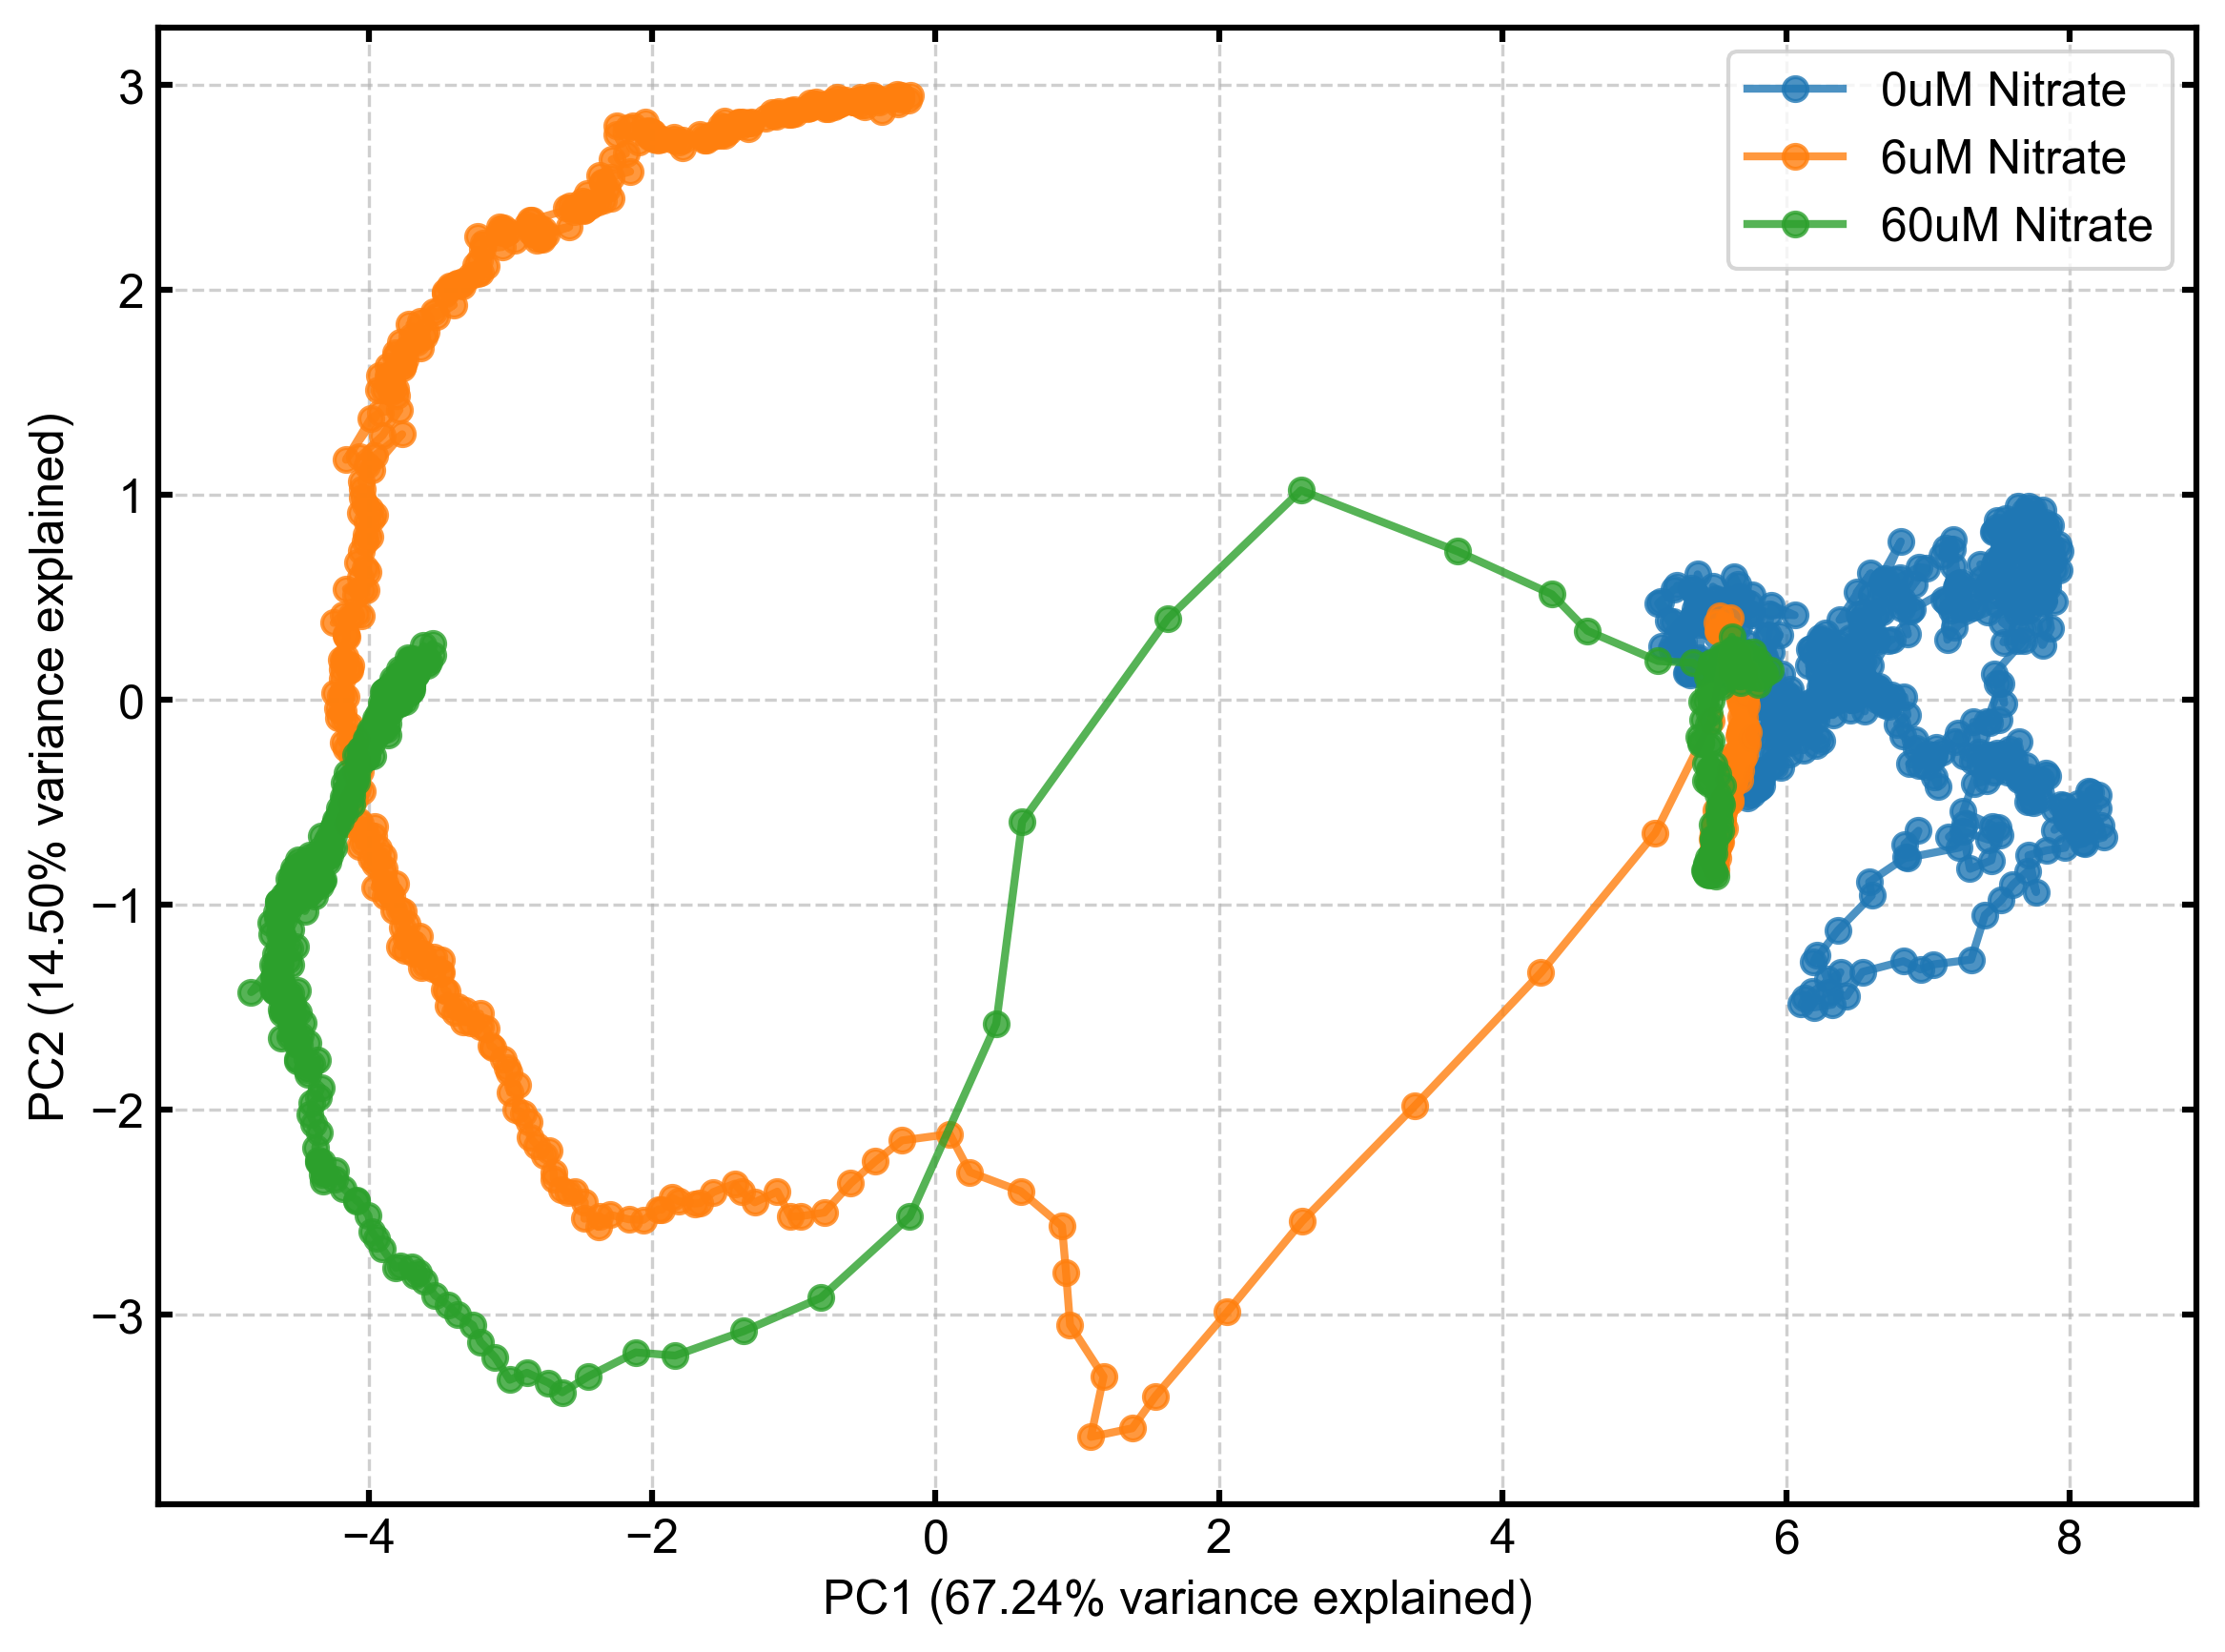

In [12]:

import matplotlib as mpl

# --- Matplotlib Configuration for PNAS-Style Publication ---
# This setup ensures fonts are embedded correctly and the style is professional.
plt.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['text.usetex'] = False

plt.rcParams.update({
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (8, 6),  # Standard 4:3 aspect ratio
    'axes.linewidth': 1.5,
    'lines.linewidth': 2.0,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
})
highlight_frames = [0, 300, 540]
highlight_markers = {0: 'o', 300: 's', 540: '^'}
# colors = ['red', 'green', 'blue']
for label in traj.keys():
    pca_traj = pca.transform(traj[label])
    plt.plot(pca_traj[:, 0], pca_traj[:, 1], label=f"{label}uM Nitrate", marker='o',
             linestyle='-', alpha=0.8)

# Add explained variance to the axis labels
explained_variance = pca.explained_variance_ratio_ * 100

# plt.title("Trajectories of Movies in PCA Space", fontsize=16)
plt.xlabel(f"PC1 ({explained_variance[0]:.2f}% variance explained)", fontsize=12)
plt.ylabel(f"PC2 ({explained_variance[1]:.2f}% variance explained)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
OUT_DIR = f"{WORKING_DIR}/images/figure3/Shimkets_Nitrate/"
os.makedirs(OUT_DIR, exist_ok=True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, '6_1.pdf'), format='pdf')

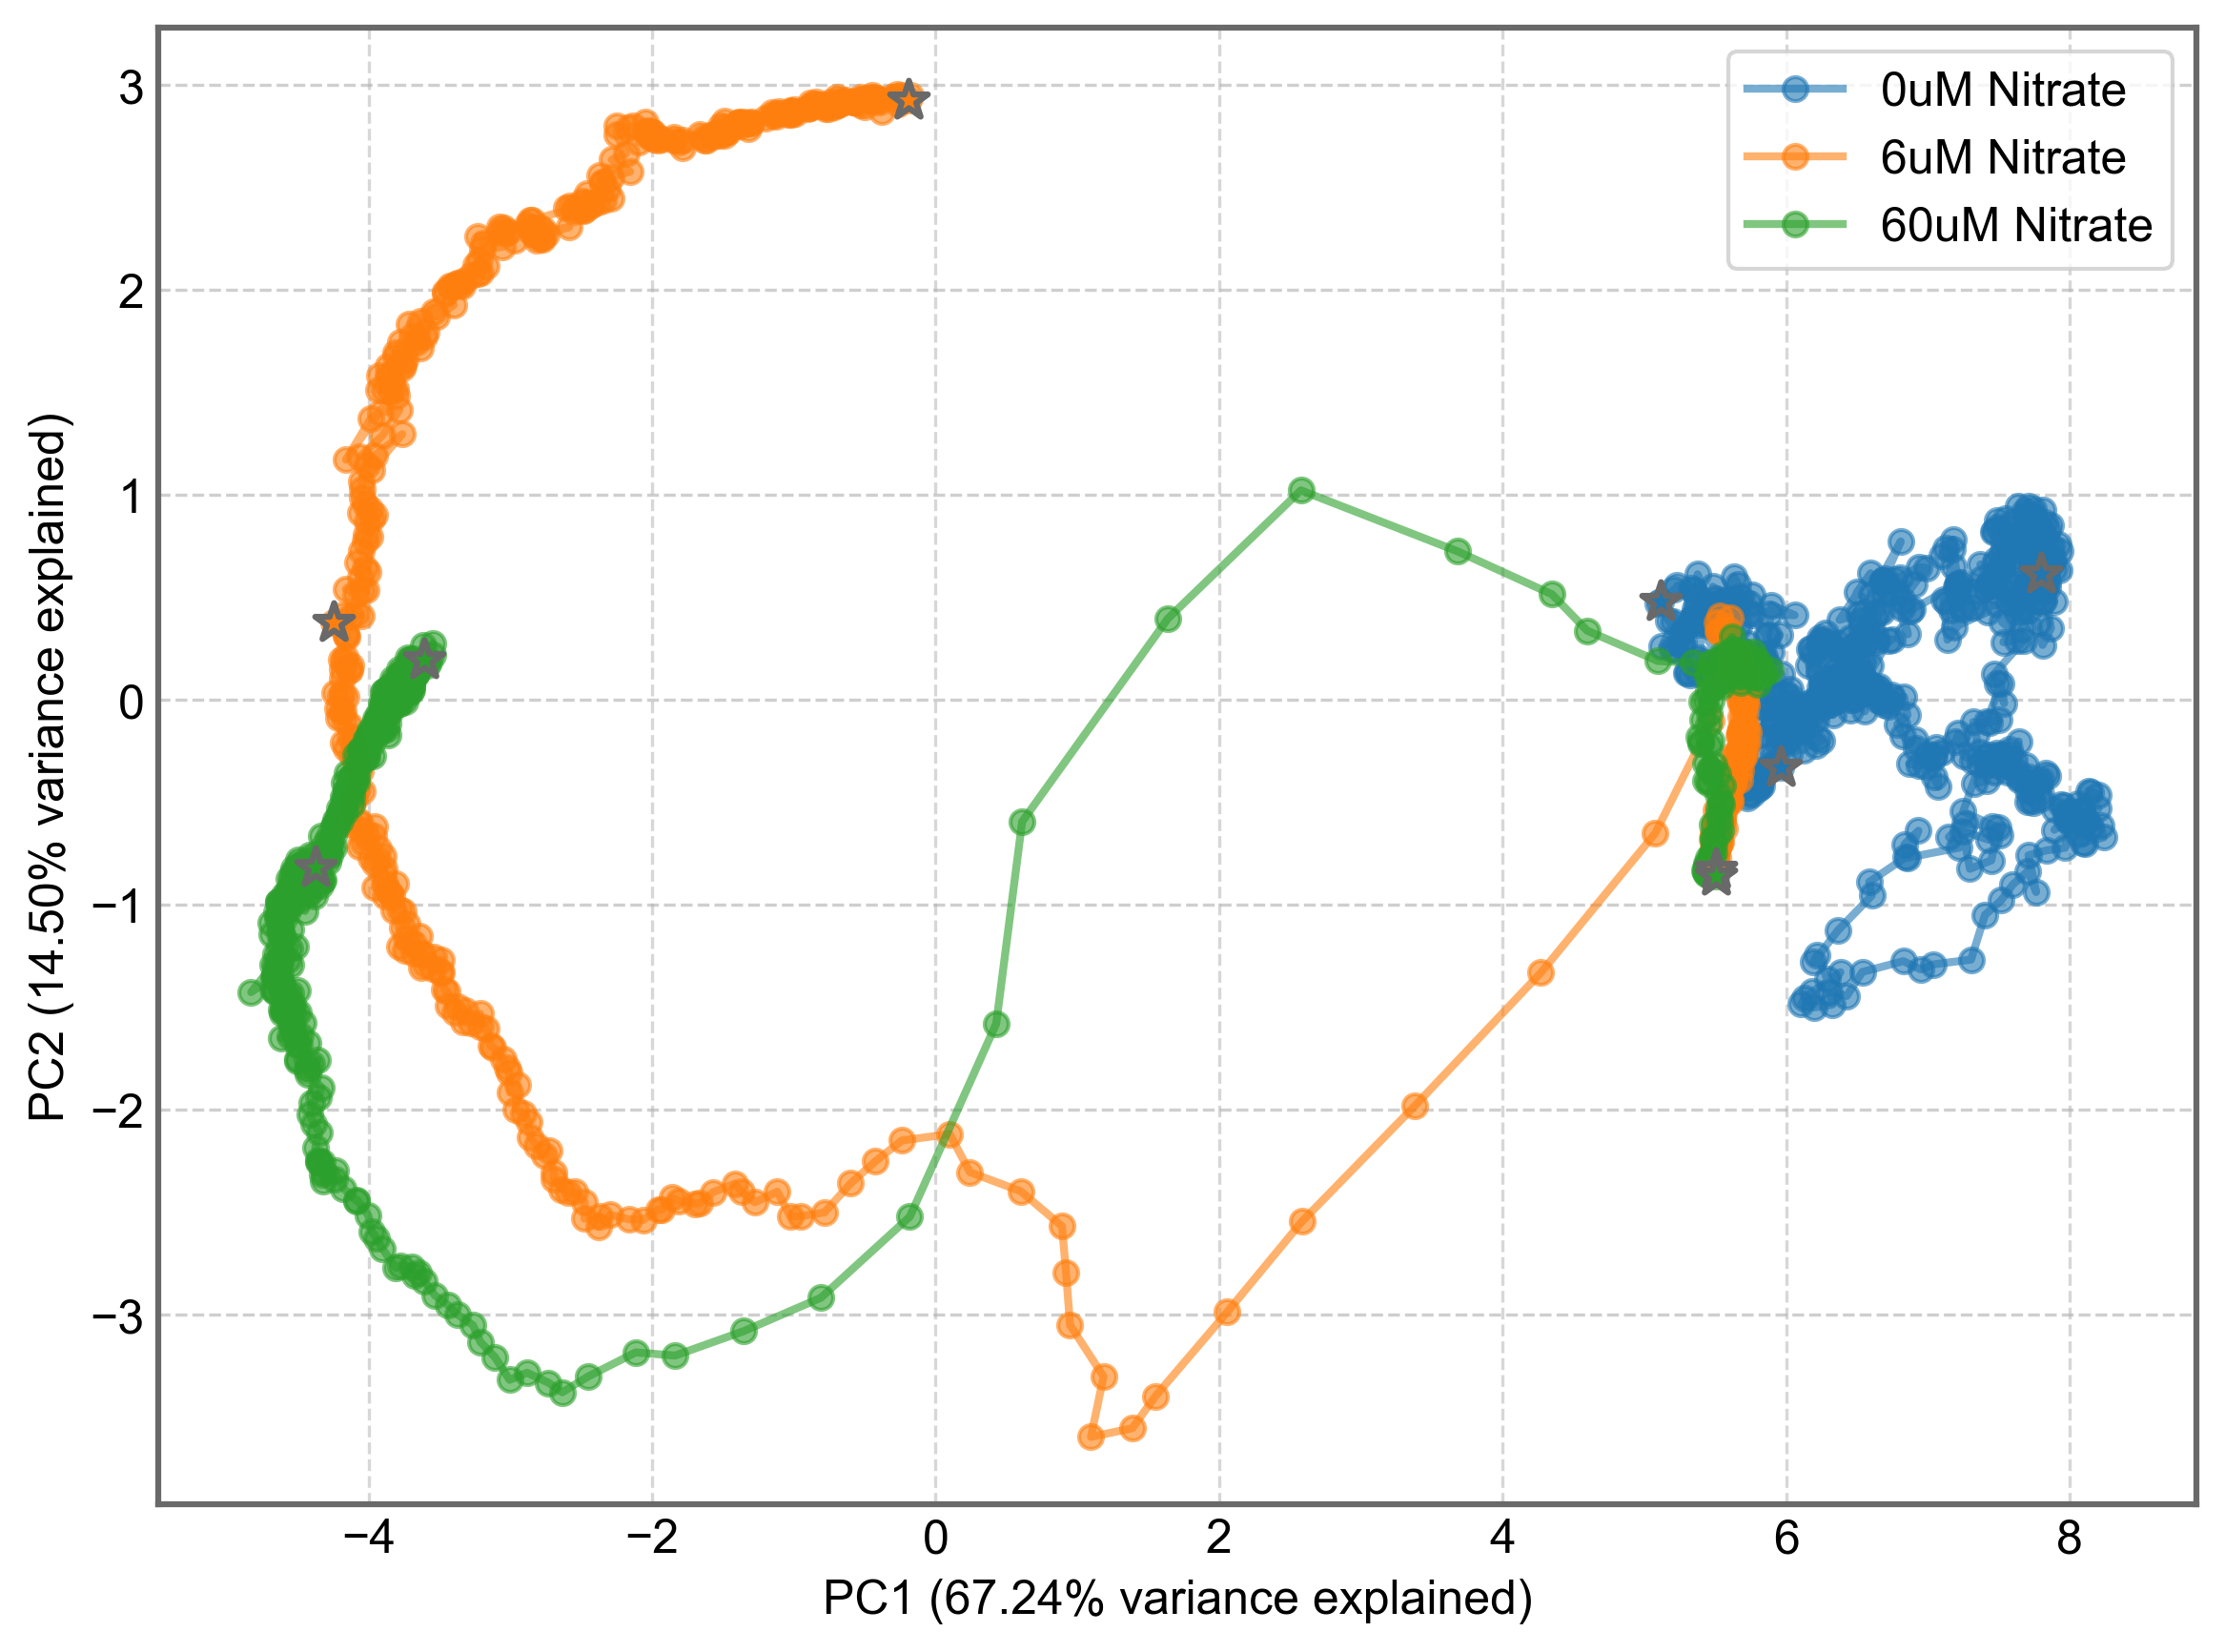

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.decomposition import PCA

# --- Matplotlib Configuration for PNAS-Style Publication ---
# This setup ensures fonts are embedded correctly and the style is professional.
plt.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['text.usetex'] = False

plt.rcParams.update({
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (8, 6),  # Standard 4:3 aspect ratio
    'axes.linewidth': 1.5,
    'lines.linewidth': 2.0,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': True,
    'ytick.right': True,
})


def style_ax(ax):
    """
    Unified styling:
    - Gray borders
    - Dashed grid behind all artists, alpha=0.5
    - No tick marks ("little spikes")
    - Transparent background
    """
    # ax.set_facecolor('none')
    # Gray frame
    for spine in ax.spines.values():
        spine.set_edgecolor('dimgray')

    # Grid under everything
    ax.set_axisbelow(True)
    ax.grid(True, axis='x', linestyle='--', alpha=0.5, zorder=0)
    # Remove tick spikes
    ax.tick_params(axis='both', which='both', length=0)


# --- Plotting Section ---
fig, ax = plt.subplots(figsize=(8, 6))

# Define frames and markers for highlighting
highlight_frames = [0, 300, -1]
highlight_markers = {0: '*', 300: '*', -1: '*'}

# Loop through each trajectory to plot
for label in traj.keys():
    # Transform the trajectory data into PCA space
    pca_traj = pca.transform(traj[label])

    # Plot the full trajectory line
    # We capture the line object to get its color for the markers
    line, = ax.plot(pca_traj[:, 0], pca_traj[:, 1], label=f"{label}uM Nitrate",
                    linestyle='-', marker="o", alpha=0.6)

    # Now, highlight the specific points on top of the line
    for frame_idx in highlight_frames:
        if frame_idx < len(pca_traj):  # Ensure the index is within bounds
            ax.scatter(
                pca_traj[frame_idx, 0],  # x-coordinate of the point
                pca_traj[frame_idx, 1],  # y-coordinate of the point
                marker=highlight_markers[frame_idx],  # Use the specific marker
                c=[line.get_color()],  # Match the facecolor to the line color
                edgecolor='dimgray',  # Set the edge color
                linewidth=1.5,  # Make the edge visible
                s=100,  # Set a larger size for visibility
                zorder=5  # Ensure markers are drawn on top of lines
            )

# Add explained variance to the axis labels
explained_variance = pca.explained_variance_ratio_ * 100

# Set plot labels, legend, and grid
ax.set_xlabel(f"PC1 ({explained_variance[0]:.2f}% variance explained)", fontsize=12)
ax.set_ylabel(f"PC2 ({explained_variance[1]:.2f}% variance explained)", fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
style_ax(ax)

# --- Save the Figure ---
OUT_DIR = f"{WORKING_DIR}/images/figure3/Shimkets_Nitrate/"
os.makedirs(OUT_DIR, exist_ok=True)

# Adjust layout and save the plot as a PDF
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, '6_1.pdf'), format='pdf')

# Display the plot
plt.show()


In [62]:
import seaborn as sns
import plotly.express as px
# Prepare a DataFrame for Seaborn
import pandas as pd

data = []
for label, points in traj.items():
    pca_traj = pca.transform(points)
    for i, (x, y) in enumerate(pca_traj):
        data.append({"Movie": label, "Index": i, "PCA1": x, "PCA2": y})
df = pd.DataFrame(data)

fig = px.scatter(
    df,
    x="PCA1",
    y="PCA2",
    color="Movie",
    hover_data=["Movie", "Index", "PCA1", "PCA2"],
    title="Trajectories of Movies in PCA Space",
    labels={
        "PCA1": f"PCA Component 1 ({pca.explained_variance_ratio_[0] * 100:.2f}% variance explained)",
        "PCA2": f"PCA Component 2 ({pca.explained_variance_ratio_[1] * 100:.2f}% variance explained)",
    },
)

# Display the interactive plot
fig.show()

# Get selected frames

In [68]:
check_frames = [0, 300, 540]
selected_dir = os.path.join(OUT_DIR, '6')
os.makedirs(selected_dir, exist_ok=True)
for label, movie_path in encoded_movies.items():
    print(movie_path)
    img_name = movie_path.split("/")[-1].split(".")[0]
    selected_frames = extract_frames(movie_path, check_frames)
    for frame, idx in zip(selected_frames, check_frames):
        image = resize_crop(frame, resize_by=23 / 20)
        cv2.imwrite(os.path.join(selected_dir, f"{img_name}_{label}_{idx}.png"), image)

        image = torch.Tensor(image).to(device).to(torch.float32) / 127.5 - 1
        image = image[None, None, :, :]
        z, _ = E.mu_var(image, None)
        synth_image = G(z, None, noise_mode='const')
        synth_image = (synth_image + 1) * 127.5
        synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()[:, :, :, 0]
        cv2.imwrite(os.path.join(selected_dir, f"{img_name}_{label}_{idx}_recon.png"), synth_image[0])


/media/xavier/Storage/feature_extraction/movie/movies/LS3934_1/LS3934 010614_563.avi
/media/xavier/Storage/feature_extraction/movie/movies/LS3934_0/LS3934 6N 031814_552.avi
/media/xavier/Storage/feature_extraction/movie/movies/LS3934_6/LS3934 60N 030414_543.avi
